### Подключаемые модули

In [197]:
import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn import metrics
from tqdm.notebook import tqdm

from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

### Загрузка данных

In [198]:
df = pd.read_csv("train.csv", index_col=["Date"], parse_dates=["Date"])
df.head(15)

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106
2010-03-09,1,1540163.53,81.21,2.577,211.531248,7.787
2010-03-12,1,1548033.78,49.27,2.708,211.607193,7.838
2010-03-19,1,1472515.79,54.58,2.720,211.215635,8.106
2010-03-26,1,1404429.92,51.45,2.732,211.018042,8.106


### Анализ данных

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6255 entries, 2010-01-10 to 2012-10-08
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Weekly_Sales  6255 non-null   float64
 2   Temperature   6255 non-null   float64
 3   Fuel_Price    6255 non-null   float64
 4   CPI           6255 non-null   float64
 5   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 342.1 KB


In [200]:

def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

store_df = df[df['Store'] == 1]
plotly_df(store_df, title="weekly_sales")


In [201]:
def moving_average(series, n):
    return np.average(series[-n:])
moving_average(store_df.Weekly_Sales, 4)

1584518.18

In [202]:
def plotMoving(series, rolling_data, n, plot_bounds=False, label="Rolling stat"):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_data, "g", label=label)
    
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_data + 1.96 * rolling_std
        lower_bound = rolling_data - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)
    plt.show()
    
def plotMovingAverage(series, n, plot_bounds=False):
    rolling_data = series.rolling(window=n).mean()
    plotMoving(series, rolling_data, n, label="Rolling average")

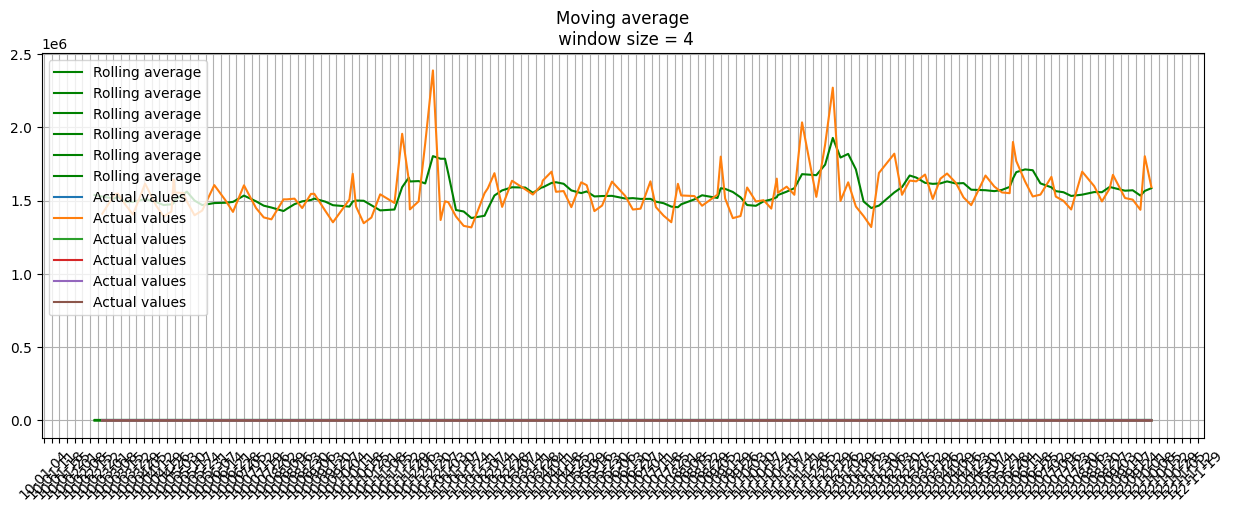

In [203]:
plotMovingAverage(store_df, 4, plot_bounds=True)

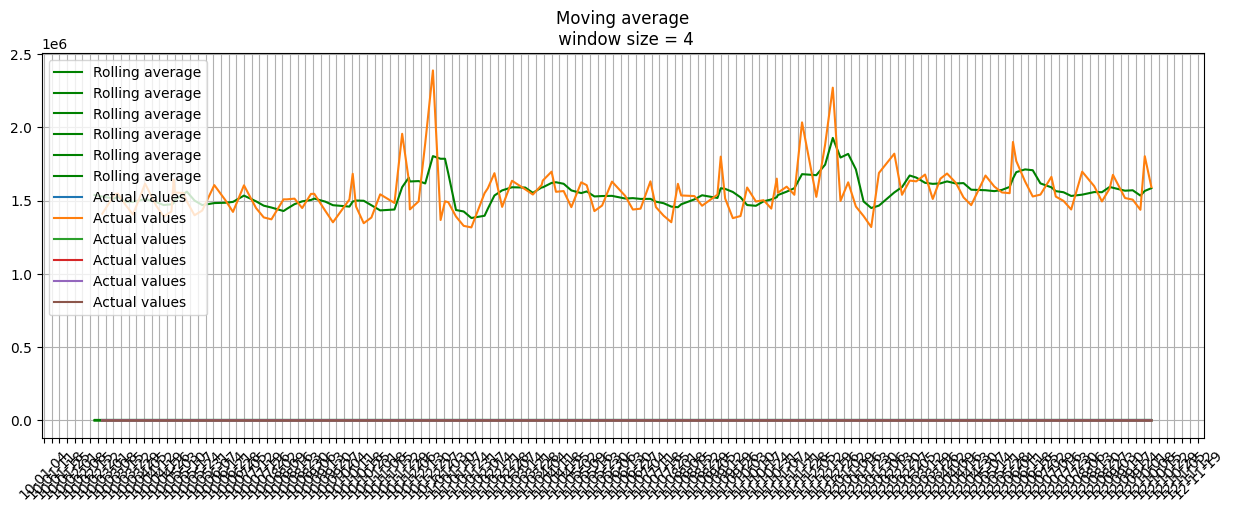

In [204]:
plotMovingAverage(store_df, 4)

In [205]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

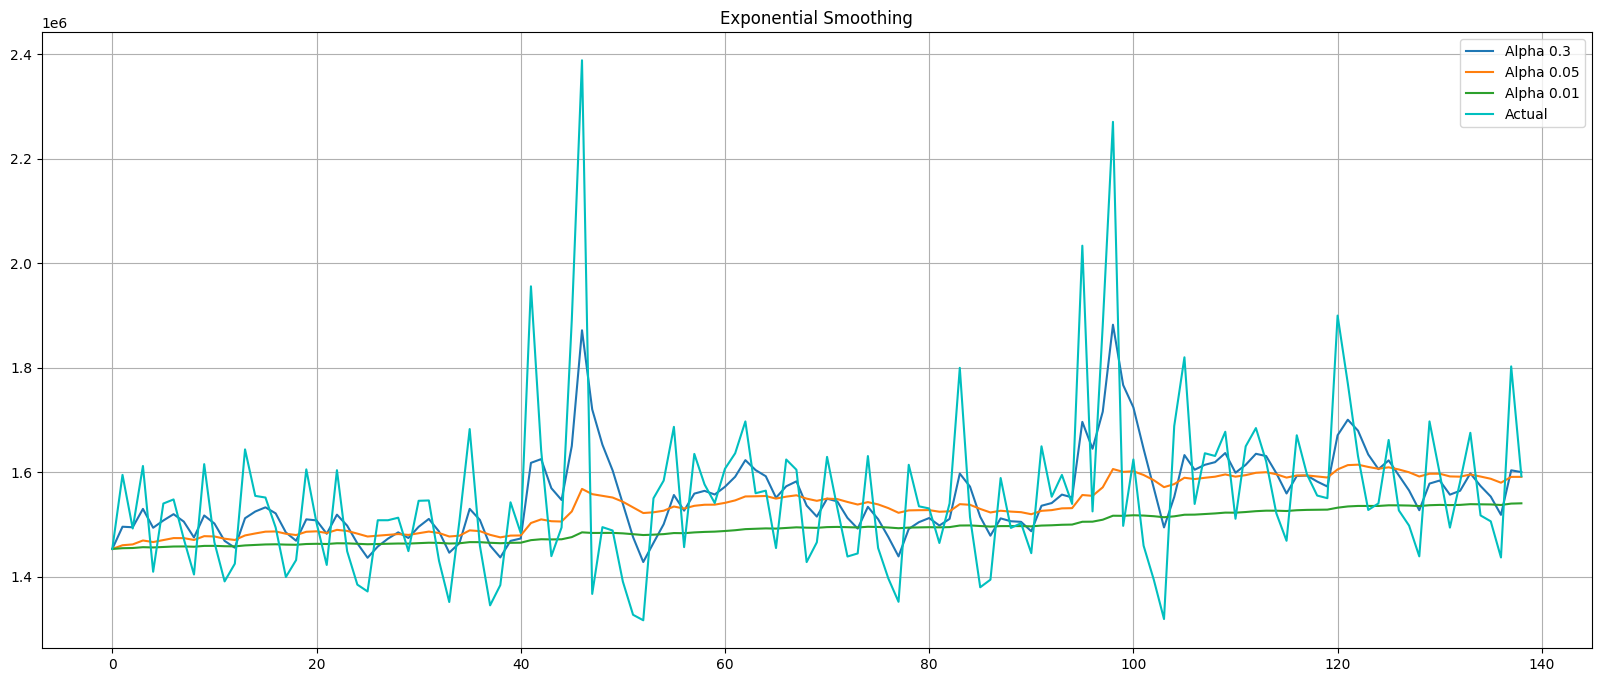

In [206]:
plt.figure(figsize=(20, 8))
for alpha in [0.3, 0.05, 0.01]:
    plt.plot(
        exponential_smoothing(store_df.Weekly_Sales, alpha), label="Alpha {}".format(alpha)
    )
plt.plot(store_df.Weekly_Sales.values, "c", label="Actual")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Exponential Smoothing")
plt.grid(True)
plt.show()

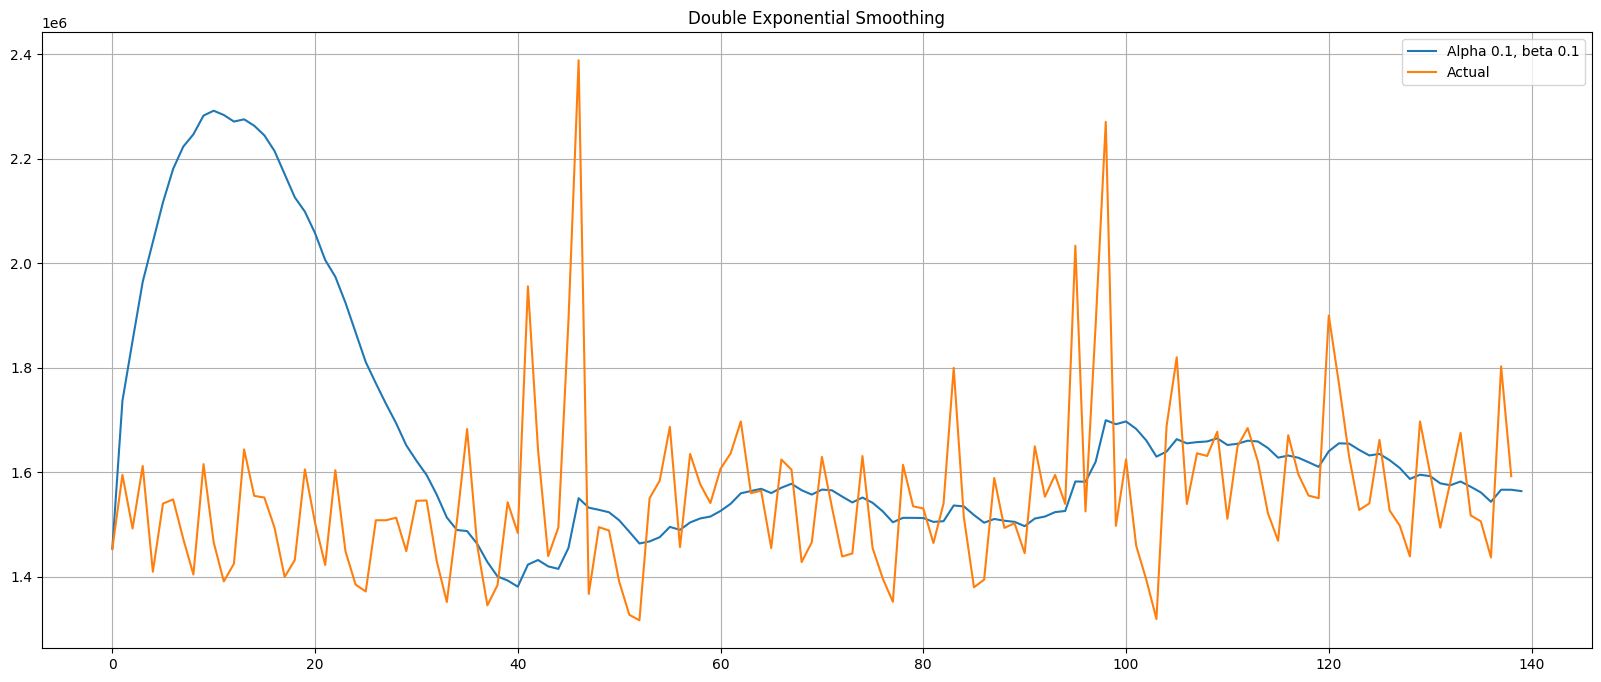

In [207]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result



plt.figure(figsize=(20, 8))
for alpha in [0.1]:
    for beta in [0.1]:
        plt.plot(
            double_exponential_smoothing(store_df.Weekly_Sales, alpha, beta),
            label="Alpha {}, beta {}".format(alpha, beta),
        )
plt.plot(store_df.Weekly_Sales.values, label="Actual")
plt.legend(loc="best")
plt.axis("tight")
plt.title("Double Exponential Smoothing")
plt.grid(True)
plt.show()

In [208]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = min(slen, len(self.series))
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=10)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen= 52,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
            scaling_factor=2.56
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = metrics.mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

In [210]:
#%%time
data = store_df.Weekly_Sales[:-52]  # отложим часть данных для тестирования
# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

# # Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

IndexError: index 17 is out of bounds for axis 0 with size 17

In [ ]:
data = store_df.Weekly_Sales
model = HoltWinters(
    data[:-4],
    slen= 52,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=4,
    scaling_factor=2.56,
)
model.triple_exponential_smoothing()

In [ ]:
def plotHoltWinters():
    # Anomalies = np.array([np.nan] * len(data))
    # Anomalies[data.values < model.LowerBond] = data.values[
    #     data.values < model.LowerBond
    # ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    #plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13)
    plt.show()

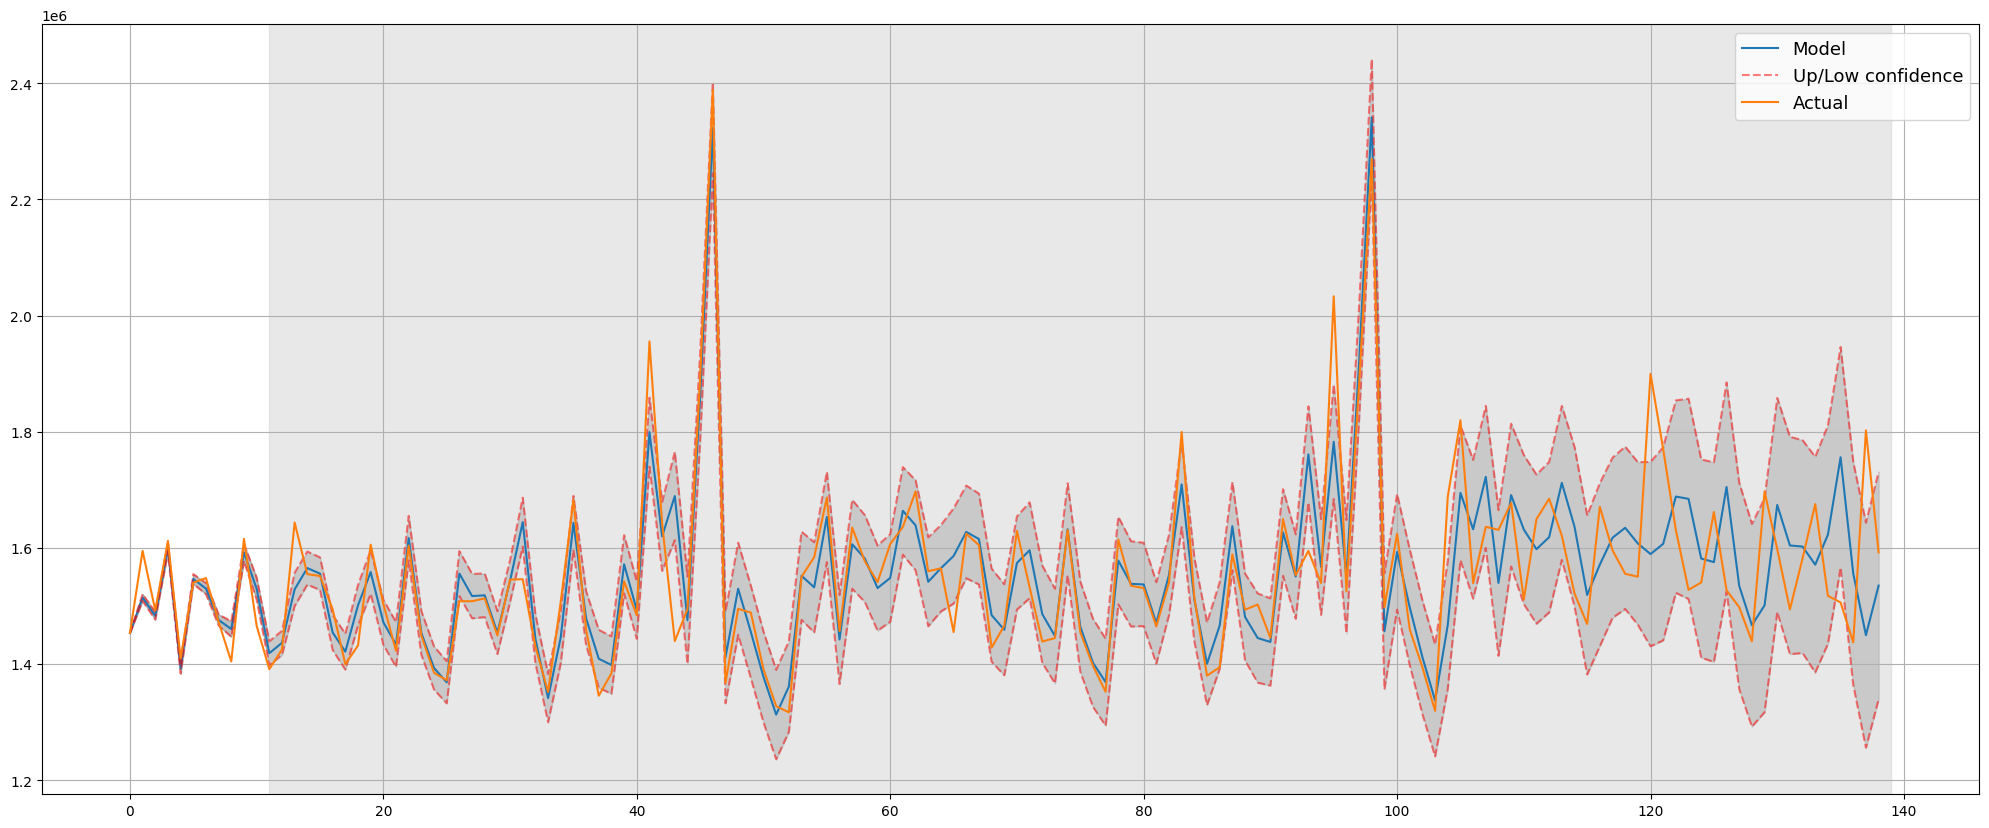

In [ ]:
plotHoltWinters()

In [ ]:
store_df.count()

Store           139
Weekly_Sales    139
Temperature     139
Fuel_Price      139
CPI             139
Unemployment    139
dtype: int64

In [ ]:
# model.result[-4:]
Y = store_df["Weekly_Sales"][-4:]
metrics.mean_absolute_percentage_error(Y, model.result[-4:])


0.12005486137805013

### Подготовка и очистка данных

### Обучение и тестирование моделей

### Сабмит